In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax_smi
jax_smi.initialise_tracking()

In [7]:
from saex.trainer_cache import main
main()

Creating SAE...
Loading model...


Some weights of the model checkpoint at gpt2 were not used when initializing FlaxGPT2LMHeadModel: {('h', '5', 'attn', 'bias'), ('h', '3', 'attn', 'bias'), ('h', '11', 'attn', 'bias'), ('h', '8', 'attn', 'bias'), ('h', '7', 'attn', 'bias'), ('h', '2', 'attn', 'bias'), ('h', '0', 'attn', 'bias'), ('h', '10', 'attn', 'bias'), ('h', '4', 'attn', 'bias'), ('h', '6', 'attn', 'bias'), ('h', '1', 'attn', 'bias'), ('h', '9', 'attn', 'bias')}
- This IS expected if you are initializing FlaxGPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxGPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading dataset...


/home/neverix/.cache/pypoetry/virtualenvs/saex-U2at97x7-py3.12/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Training for 20000 iterations


Learning rate: 6e-05 warmed up for 128 iterations and cycled every 100000 iterations


Training SAE:  18%|█▊        | 3583/20000 [05:10<23:44, 11.53it/s, dead=0.00048828125, l0=191.65668, loss=0.070117235, loss_death=1.4662513e-05, loss_reconstruction=0.030156579, loss_sparsity=249.66245, max_time_since_fired=502.0, var_explained=0.7633971, tokens_processed=7340032]   


PatcherException: One of the patches failed

In [ ]:
# toy model of computation in superposition?

In [ ]:
from matplotlib import pyplot as plt
import jax.numpy as jnp
from tqdm import tqdm
import jax

In [ ]:
n = 3
# x = jax.nn.one_hot(jnp.arange(n), n)
diff = jnp.power(2, jnp.arange(n))[None, :]
x = jnp.arange(2 ** n)[:, None] % (diff * 2) < diff
y = (x[:, :, None] & x[:, None, :]).reshape(x.shape[0], -1)

In [ ]:
# this is where the fun begins
def reverse_engineer_bound(x, y, d, k=jax.random.PRNGKey(0), la=1e-3, nit=100_000, d_max=n*n):
    # initialize = lambda x: jnp.ones(x)
    def initialize(x, k):
        k, s = jax.random.split(k)
        if len(x) == 1:
            return jax.random.normal(k, x), s
        else:
            return jax.nn.initializers.he_normal()(k, x), s
    # w1, k = initialize((x.shape[-1], d_max), k)
    k, s = jax.random.split(k); w1 = jax.random.bernoulli(
        s, jnp.log(x.shape[-1]) ** 2 / (d ** 0.5), (x.shape[-1], d_max)).astype(jnp.float32)
    w2, k = initialize((d_max, y.shape[-1]), k)
    b1, k = initialize((d_max,), k)
    # b1 = jnp.full((d_max,), -1.)
    b2, k = initialize((y.shape[-1],), k)
    def loss_fn(p):
        w1, b1, w2, b2 = p
        return jnp.abs(jax.nn.relu(x @ w1 + b1) * (jnp.arange(d_max) < d) @ w2 + b2 - y).max()
    
    lwg = jax.value_and_grad(loss_fn)
    def scanner(p, _):
        loss, grad = lwg(p)
        p = jax.tree.map(lambda x, y: x - y * la, p, grad)
        return p, None
    wb, _ = jax.lax.scan(scanner, (w1, b1, w2, b2), jnp.arange(nit))
    
    return loss_fn(wb)


@jax.jit
def try_train(x, y, d):
    k = jax.random.PRNGKey(3)
    nit = 10_000
    t = 1_000
    lamin, lamax = 1e-5, 1e-1
    la = jnp.exp(jnp.linspace(jnp.log(lamin), jnp.log(lamax), t))
    keys_ensemble = jax.random.split(k, t)
    return jax.vmap(reverse_engineer_bound, in_axes=(None, None, None, 0, 0, None))(x, y, d, keys_ensemble, la, nit).min()

# jax.vmap(try_train, in_axes=(None, None, 0))(x, y, jnp.arange(1, 9))
ds = jnp.arange(0, n*n+1)
losses = jax.vmap(try_train, in_axes=(None, None, 0))(x, y, ds)

(0.0, 0.5)

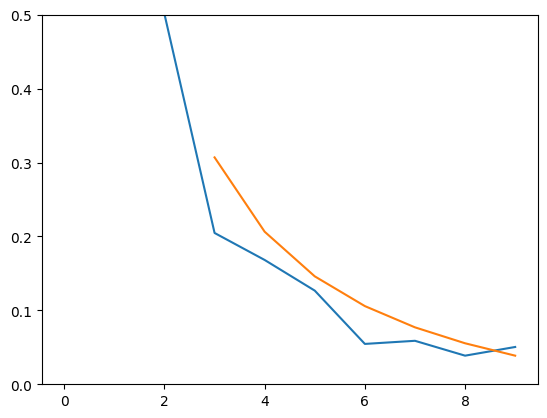

In [ ]:
plt.plot(ds, losses)
seq = (jnp.log(n) ** 2 / ds[n:])
plt.plot(ds[n:], seq - seq.min() + losses.min())
plt.ylim(0, 0.5)